# SOSE Data
Bottom Temperature and Salinity to compare with ECCOv4r3 and WOA products

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.2.76:38511")
client

Client Scheduler: tcp://10.32.2.76:38511 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()

In [4]:
coords = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700) #ds split into coords
dsr = ds.reset_coords(drop=True).roll(XC=700, XG=700) #ds dropping coords so it just holds data variables

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


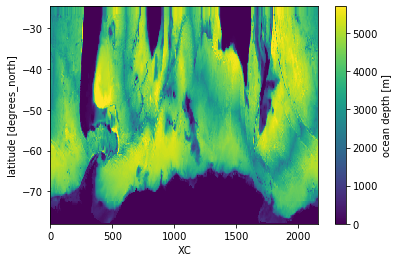

In [5]:
#checking to see if `roll` worked
coords.Depth.drop('XC').plot()

In [7]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time')

In [64]:
surface_mask = (coords.hFacC[0]>0).load()

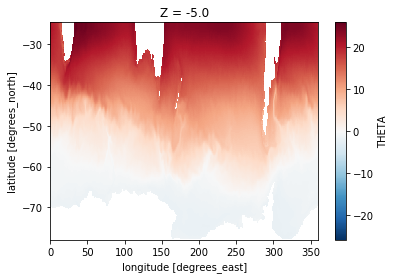

In [9]:
sst_mean.where(surface_mask).plot()

In [49]:
ds.XC[180]

<xarray.DataArray 'XC' ()>
array(30.083334, dtype=float32)
Coordinates:
    XC       float32 30.083334
Attributes:
    axis:           X
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [50]:
ds.XC[179]

<xarray.DataArray 'XC' ()>
array(29.916668, dtype=float32)
Coordinates:
    XC       float32 29.916668
Attributes:
    axis:           X
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

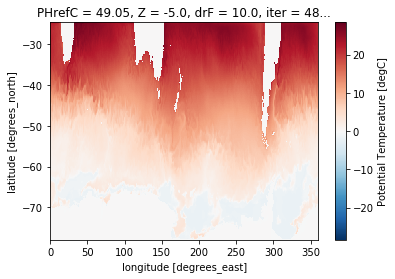

In [68]:
ds.THETA[0,0].plot()

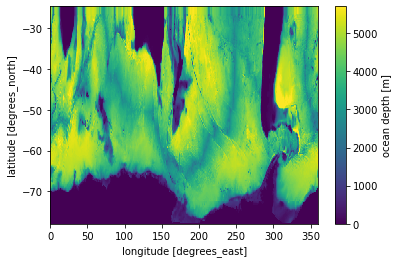

In [84]:
ds.Depth.plot()

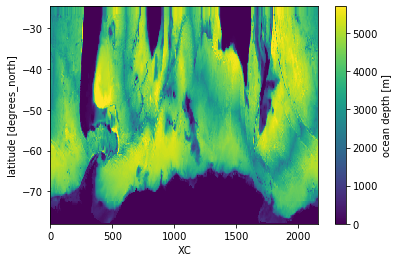

In [83]:
ds.Depth.roll(XC=700, roll_coords=True).drop('XC').plot()

In [48]:
#WG boundaries (65˚W, 30˚E; 80˚S, 55˚S)
#WG model's boundaries (-77.87497˚S, -55.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 137
left_lon =  310
right_lon = 880

In [47]:
coords.Depth.isel(YC=137)

<xarray.DataArray 'Depth' (XC: 2160)>
dask.array<getitem, shape=(2160,), dtype=float32, chunksize=(2160,), chunktype=numpy.ndarray>
Coordinates:
    YC       float32 -55.041634
  * XC       (XC) float32 243.41667 243.58334 243.75 ... 243.08334 243.25
Attributes:
    coordinate:     XC YC
    long_name:      ocean depth
    standard_name:  ocean_depth
    units:          m

In [49]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

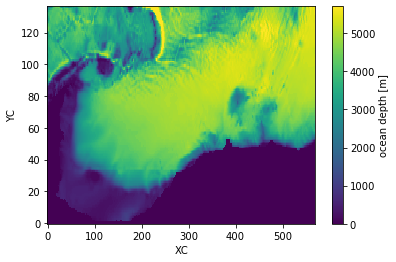

In [54]:
coords.Depth.isel(**lat_range, **lon_range).plot()#.drop(['XC', 'YC']).plot()

In [53]:
dsr = dsr.drop(['XC', 'YC', 'XG', 'YG'])
coords = coords.drop(['XC', 'YC', 'XG', 'YG'])

In [55]:
temp_wg = dsr.THETA.isel(**lat_range, **lon_range)

In [56]:
temp_wg_mean = temp_wg.mean(dim='time')
temp_wg_mean

<xarray.DataArray 'THETA' (Z: 42, YC: 137, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 137, 570), dtype=float32, chunksize=(42, 137, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
Dimensions without coordinates: YC, XC

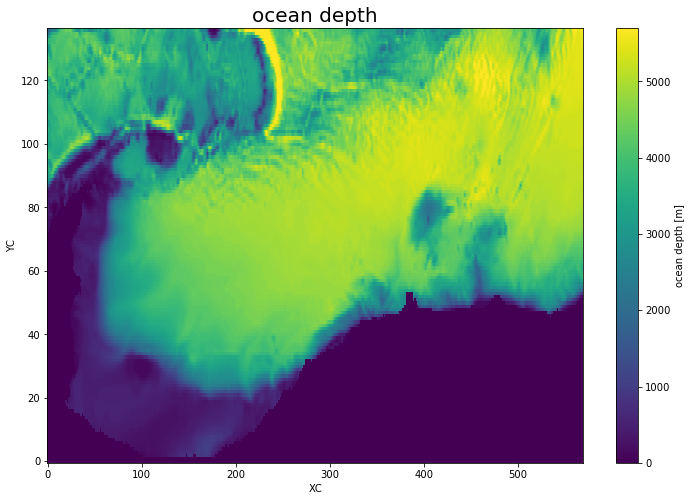

In [57]:
coords.Depth.isel(**lat_range, **lon_range).plot(figsize=(12,8))
plt.title('ocean depth', fontsize=20);

In [58]:
#this gives us the depth of the bottom cell
depth_max = dsr.Z.where(temp_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [59]:
depth_max

<xarray.DataArray 'Z' (YC: 137, XC: 570)>
dask.array<nanmax-aggregate, shape=(137, 570), dtype=float32, chunksize=(137, 570), chunktype=numpy.ndarray>
Dimensions without coordinates: YC, XC

In [60]:
bottom_temp = temp_wg_mean.sel(Z=depth_max.fillna(0.))

In [61]:
bottom_temp.load()

<xarray.DataArray 'THETA' (YC: 137, XC: 570)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [5.9242516 , 5.749188  , 5.574403  , ..., 0.839294  , 0.855196  ,
        0.8651392 ],
       [6.2930045 , 6.1563973 , 6.014178  , ..., 0.871197  , 0.8897323 ,
        0.904045  ],
       [6.592732  , 6.4988494 , 6.4041686 , ..., 0.89763826, 0.91534024,
        0.9297845 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

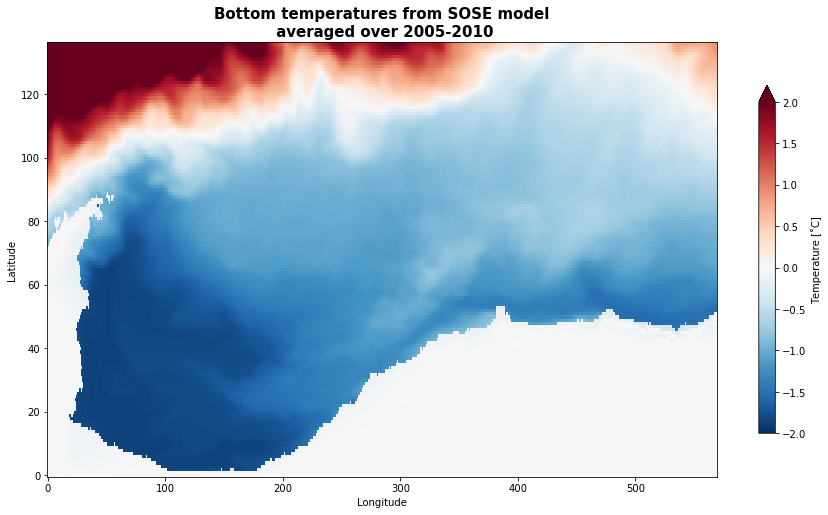

In [63]:
bottom_temp.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmax=2)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');

In [68]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

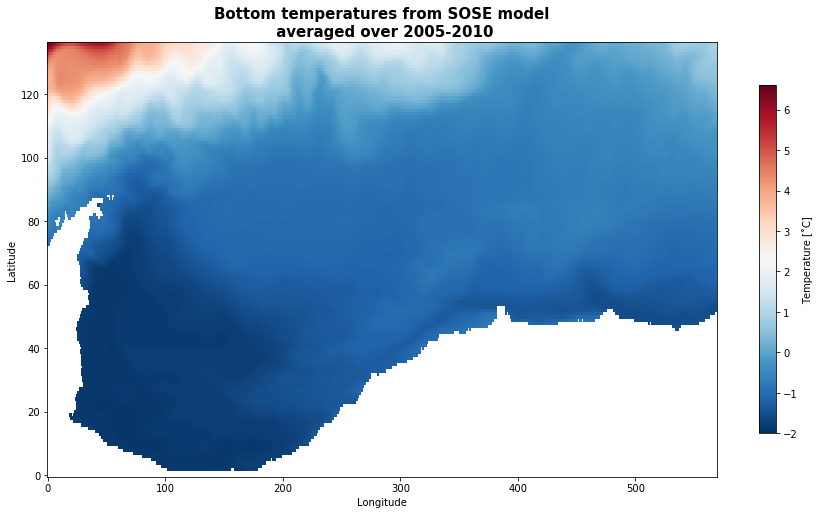

In [122]:
bottom_temp.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmin=-2, vmax=6.6)

#plt.xticks(labels=(-65, -50, -35, -20, -5, 25))
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');

## BOTTOM SALT

In [73]:
slt_wg = dsr.SALT.isel(**lat_range, **lon_range)

In [74]:
slt_wg_mean = slt_wg.mean(dim='time')
slt_wg_mean

<xarray.DataArray 'SALT' (Z: 42, YC: 137, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 137, 570), dtype=float32, chunksize=(42, 137, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
Dimensions without coordinates: YC, XC

In [75]:
#this gives us the depth of the bottom cell
depth_max_slt = dsr.Z.where(slt_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [76]:
bottom_slt = slt_wg_mean.sel(Z=depth_max_slt.fillna(0.)).load()

In [77]:
bottom_slt

<xarray.DataArray 'SALT' (YC: 137, XC: 570)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.05997 , 34.057858, 34.053898, ..., 33.94047 , 33.93996 ,
        33.939095],
       [34.05739 , 34.059486, 34.06011 , ..., 33.94124 , 33.94145 ,
        33.941498],
       [34.049725, 34.054535, 34.058033, ..., 33.941635, 33.94203 ,
        33.942642]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

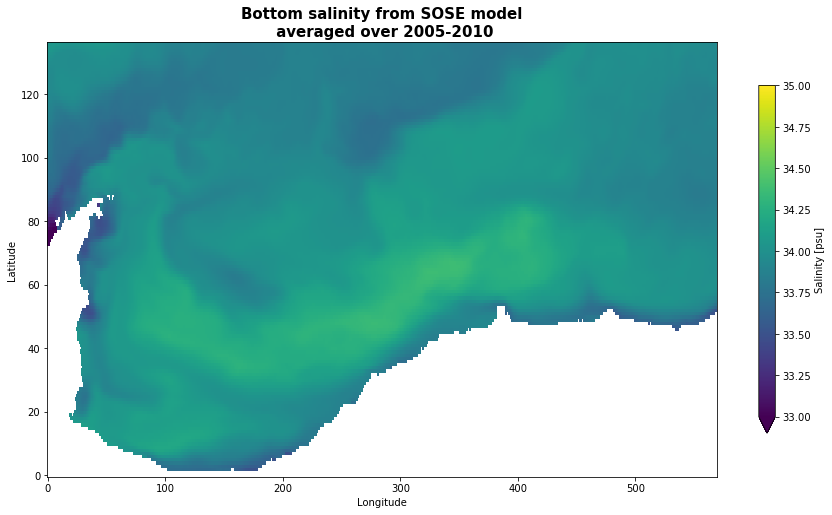

In [81]:
bottom_slt.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'}, vmin=33, vmax=35)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');